In [1]:
import gluonbook as gb
from mxnet import image, gluon, nd, contrib
import numpy as np
np.set_printoptions(2)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 物体检测和边界框 

参考：[物体检测和边界框](http://zh.gluon.ai/chapter_computer-vision/bounding-box.html)

图片链接：https://github.com/q735613050/images/blob/master/test/catdog.jpg

Populating the interactive namespace from numpy and matplotlib


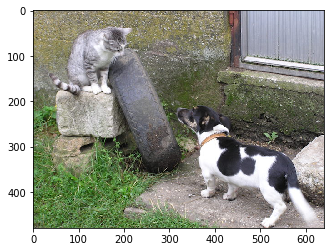

In [2]:
%pylab inline
img = image.imread('../data/catdog.jpg').asnumpy()
plt.imshow(img)
plt.show()

In [31]:
# 注意坐标轴原点是图片的左上角。bbox 是 bounding box 的缩写。
dog_bbox = [300, 200, 600, 360]
cat_bbox = [30, 30, 230, 200]

In [32]:
# 将边界框（左上 x、左上 y，右下 x，右下 y）格式转换成 matplotlib 格式：
# （（左上 x，左上 y），宽，高）。
def bbox_to_rect(bbox, color):
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

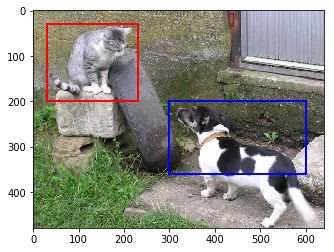

In [33]:
fig, ax = plt.subplots()
plt.imshow(img)
ax.add_patch(bbox_to_rect(dog_bbox, 'blue'))
ax.add_patch(bbox_to_rect(cat_bbox, 'red'))
ax.autoscale_view()
plt.show()

# 锚框

> 物体识别算法通常会在输入图片中采样大量的区域，然后判断这些区域是否有我们感兴趣的物体，以及进一步调整区域边缘来更准确预测物体的真实边界框。不同的模型使用不同的区域采样方法，这里我们介绍其中的一种：它以每个像素为中心生成数个大小和比例不同的被称之为**锚(mao)框**（anchor box）的边界框。

假设输入图片高为 $h$，宽为 $w$，那么大小为 $s\in (0,1]$ 和比例为 $r > 0$ 的锚框形状是：
$$\left( ws\sqrt{r}, \  \frac{hs}{\sqrt{r}}\right)$$
确定其中心点位置便可以固定一个锚框。

-------
我们假设锚框的高和宽分别为 $h_1$，$w_1$，则有：
$$
\begin{align} 
&s^2 = \frac{w_1h_1}{wh}\\
&\frac{w_1}{h_1} = \frac{w}{h}r
\end{align}
$$

----------

我们可以通过不同的 $s$ 和 $r$，以及中心位置，来遍历所有可能的区域。虽然这样可以覆盖真实边界框，但会使得计算很复杂。通常我们进行采样，使得尽量很好的贴近真实边界框。 例如我们可以首先固定一个比例 $r_1$，然后采样 $n$ 个不同的大小 $s_1\,\ldots\,s_n$。然后固定一个大小 $s_1$，采样 $m$ 个不同的比例 $r_1\,\ldots\,r_m$。这样对每个像素我们一共生成 $n+m-1$ 个锚框。对于整个输入图片，我们将一共生成 $wh(n+m-1)$ 个锚框。

上述的采样方法实现在 `contribe.ndarray` 中的 `MultiBoxPrior` 函数。通过指定输入数据（我们只需要访问其形状），锚框的采样大小和比例，这个函数将返回所有采样到的锚框。

In [6]:
h, w = img.shape[0:2]
x = nd.random.uniform(shape=(1, 3, h, w))  # 构造一个输入数据，
y = contrib.nd.MultiBoxPrior(x, sizes=[.75, .5, .25], ratios=[1, 2, .5])
y.shape

(1, 1532800, 4)

`y.shape` 其返回结果格式为`(批量大小，锚框个数，4)`。可以看到我们生成了 $1$ 百万以上个锚框。将其变形成 `(高，宽，n+m-1，4)` 后，我们可以方便的访问以任何一个像素为中心的所有锚框。下面例子里我们访问以 `(250, 250)` 为中心的 $5$ 个锚框。它们各有四个元素，同前一样是左上和右下的 $x$、$y$ 轴坐标，但被分别除以了高和宽使得数值在 $0$ 和 $1$ 之间。

In [20]:
boxes = y.reshape((h, w, 5, 4))
boxes[250, 250, :, :]


[[ 0.11  0.15  0.67  0.9 ]
 [ 0.2   0.27  0.58  0.77]
 [ 0.3   0.4   0.48  0.65]
 [-0.01  0.26  0.79  0.79]
 [ 0.19 -0.01  0.59  1.05]]
<NDArray 5x4 @cpu(0)>

In [21]:
def show_bboxs(axes, bboxs, labels=None):
    colors = ['b', 'g', 'r', 'k', 'm']
    for i, bbox in enumerate(bboxs):
        color = colors[i%len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va="center", ha="center", fontsize=9, color='white',
                      bbox=dict(facecolor=color, lw=0))

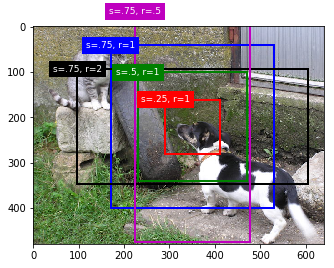

In [24]:
bbox_scale = nd.array((w, h, w, h))  # 需要乘以高和宽使得符合我们的画图格式。
fig, ax = plt.subplots()
plt.imshow(img)
show_bboxs(ax, boxes[220, 350, :, :]*bbox_scale, ['s=.75, r=1', 's=.5, r=1', 's=.25, r=1', 's=.75, r=2', 's=.75, r=.5'])

# IoU：交集除并集

在介绍如何使用锚框参与训练和预测前，我们先介绍如何判断两个边界框的距离。我们知道集合相似度的最常用衡量标准叫做 `Jaccard` 距离。给定集合 $A$ 和 $B$，它的定义是集合的交集除以集合的并集：
$$J(A,B) = \frac{|A\cap B|}{| A \cup B|}$$

边界框指定了一块像素区域，其可以看成是像素点的集合。因此我们可以定类似的距离，即我们使用两个边界框的相交面积除以相并面积来衡量它们的相似度。这被称之为交集除并集（Intersection over Union，简称IoU）。它的取值范围在 $0$ 和 $1$ 之间。$0$ 表示边界框不相关，$1$ 则表示完全一样。
![](http://static.zybuluo.com/xinet/vpiu0bjpu2of8s7ijzc8myut/iou.png)

# 训练

在训练时，每个锚框都表示成一个样本。对每个样本我们需要预测它是否含有我们感兴趣的物体，以及如果是那么预测它的真实边界框。在训练前我们首先需要为每个锚框生产标签。这里标签有两类，第一类是对应的物体的标号。一个常用的构造办法是对每个真实的边界框，我们选取一个或多个与其相似的锚框赋予它们这个真实边界框里的物体标号。具体来说，对一个训练数据中提供的真实边界框，假设其对应物体标号 $i$，我们选取所有与其 IoU 大于某个阈值（例如 $0.5$）的锚框。如果没有这样的锚框，我们就选取 IoU 值最大的那个。然后将选中的锚框的物体标号设成 $i+1$。如果一个锚框没有被任何真实边界框选中，即不与任何训练数据中的物体足够重合，那么将赋予标号 $0$，代表只含有背景。我们经常将这类锚框叫做负类锚框，其余的则称之为正类。

对于正类锚框，我们还需要构造第二类标号，即它们与真实边界框的距离。一个简单的方法是它与真实边界框的坐标差。但因为有图片边框的限制，这些差值都在 $-1$ 与 $1$ 之间，这使得在模型预测时变得复杂。通常我们会将其进行非线性变化来使得其数值上更加均匀来方便模型预测。

下面来看一个具体的例子。我们将读取的图片中的猫和狗边界框定义成真实边界框，其中第一个元素为类别号（从 $0$ 开始）。然后我们构造四个锚框，其与真实边界框的位置如下图示。



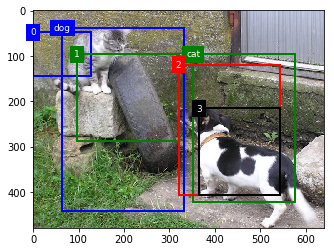

In [26]:
ground_truth = nd.array([[0, .1, .08, .52, .92], [1, .55, .2, .9, .88]])
anchors = nd.array([[ 0, .1, .2, .3], [.15, .2, .5, .6],
                    [.5, .25, .85, .85], [.57, .45, .85, .85]])


fig, ax = plt.subplots()
plt.imshow(img)
show_bboxs(ax, ground_truth[:,1:]*bbox_scale, ['dog','cat'])
show_bboxs(ax, anchors*bbox_scale, ['0', '1', '2', '3']);

我们可以通过 `contrib.nd` 模块中的 `MultiBoxTarget` 函数来对锚框生成标号。我们把锚框和真实边界框加上批量维（实际中我们会批量处理数据），然后构造一个任意的锚框预测结果，其形状为（批量大小，类别数 $+1$，锚框数），其中第 $0$ 类为背景。

In [27]:
out = contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),
                                ground_truth.expand_dims(axis=0),
                                nd.zeros((1,3,4)))